# 코드 수정을 반복하는 데이터 분석 Agent

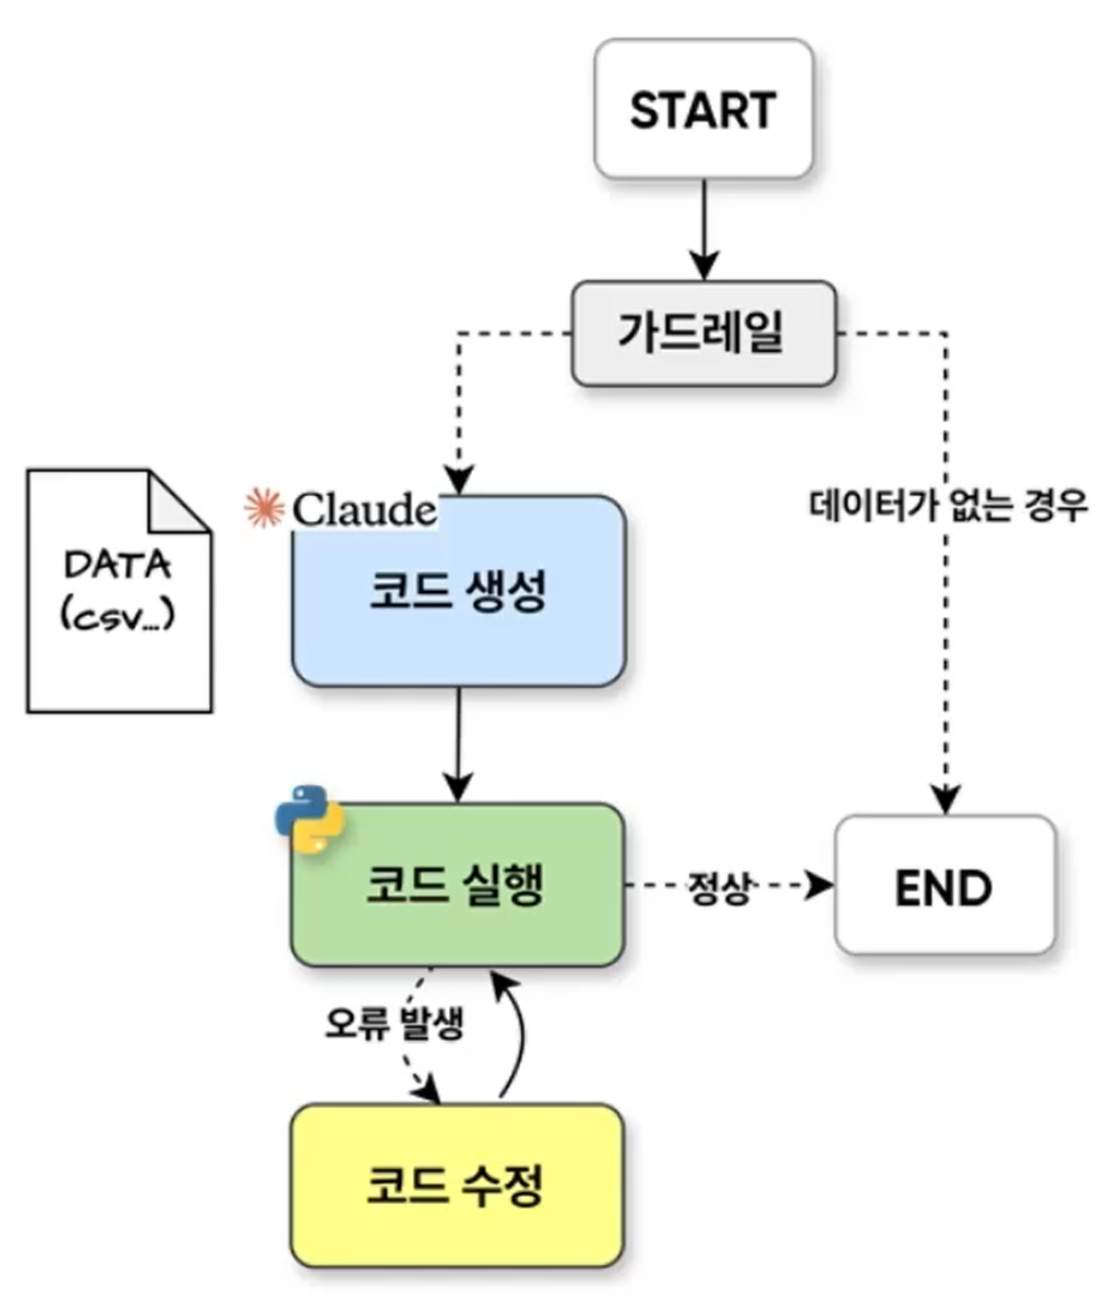

In [ ]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPEN_API_KEY")
_set_env("ANTHROPIC_API_KEY")

In [ ]:
## 데이터 전처리 코드 작성을 위한 코드 수정 반복 Agent

실습 데이터 : 타이타닉 데이터 셋 https://www.kaggle.com/competitions/titanic/overview

## Step 1. 데이터 전처리에 참고할 Context 제공하기 - tool

`discribe()`: 데이터 갯수, 평균, 표준편차, 최소/최대값, 4분위 (25%, 50%, 75%) 값을 포함한 통계 제공

In [ ]:
from langchain_core.tools import tool
import pandas as pd

@tool
def describe_data(csv: str) -> str:
    """Describe the data column in the dataframe.
    
    Args:
        csv: csv data path string
    """
    df = pd.read_csv(csv)
    describe_str = f"""Data: {csv}""" + df.describe(include='all').to_string()
    return describe_str

In [ ]:
tools = [describe_data]

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

llm_gpt = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm_gpt.bind_tools(tools, tool_choice="any")

In [ ]:
response = llm_with_tools.invoke(
    "https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/diabetes.csv 이 데이터를 전처리 해주세요."
)

In [ ]:
response.tool_calls[0]['args']

## Step 2. 코드 작성을 위한 프롬프트 + 구조화 코드 출력

In [ ]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

GENERATE_CODE_TEMPLATE = """
Given the following pandas `describe()` output of a dataset,

write a **directly executable Python code** to:
1. handle missing values,
2. convert categorical values,
3. ...any additional preprocessing needed,
4. prepare the dataset for machine learning.

Here is the describe result of the dataset:
\n ------- \n {context} \n ------- \n

Do not wrap the code in a fuction and the response in any backticks or anything else.
The code should be written as a flat acript, so that it can be run immediately
and any errors will be visible during execution.
Ensure any code you provide can be executed \n
with all required imports and variables defined. Structure your answer with a 
description of the code solution. \n
Then list the import. And finally list the functioning code block.
"""

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", GENERATE_CODE_TEMPLATE)
    ]
)

In [ ]:
from langchain_anthropic import ChatAnthropic

llm_claude = ChatAnthropic(model="claude-3-7-sonnet-20250219")

In [ ]:
response.tool_calls[0]['args']

In [ ]:
tool_result = describe_data.invoke(response.tool_calls[0]['args'])

In [ ]:
print(tool_result)

In [ ]:
generated_code = llm_claude.invoke(
    # code_gen_prompt의 {context} 부분에 tool_result가 들어가게 됨
    code_gen_prompt.format_messages(context=tool_result)
)

print("generated_code", generated_code)
code_structurer = llm_gpt.with_structured_output(code)
code_solution = code_structurer.invoke(generated_code.content)
print("code_solution", code_solution)

In [ ]:
print(code_solution.prefix)

In [ ]:
print(code_solution.imports)

In [ ]:
print(code_solution.code)

## Step 3. Graph 생성하기

1) state 생성하기

In [ ]:
from langgraph.graph import StateGraph, MessagesState

# state 생성시 plna_execute과 같이 TypedDict를 사용해도 되고
# MessagesState를 상속하면 messages라는 키값을 필수로 가지게 된다.
class State(MessagesState):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        context : Data summary
        generation : Code solution
        iterations : Number of tries
    """

    error: str  # yes or no
    context: str  # csv describe 결과값
    generation: str  # 생성된 코드
    iteration: int

graph_builder = StateGraph(State)

### 사용자 입력을 기반으로 데이터 Context 도구 호출을 결정하는 노드

In [ ]:
from langchain_core.tools import tool
import pandas as pd

@tool
def describe_data(csv: str) -> str:
    """Describe the data column in the dataframe.
    
    Args:
        csv: csv data path string
    """
    df = pd.read_csv(csv)
    describe_Str = f"""Data: {csv}""" + df.describe(include='all').to_string()
    return describe_Str

In [ ]:
llm_with_tools = llm_gpt.bind_tools(tools=[describe_data]) # , tool_choice="any"를 사용하지 않고, csv와 같이 데이터 분석과 관련된 질의가 아닌경우 종료하는 guardrail을 추가할 예정

In [ ]:
def chatbot(state: State):
    print("##### HI ! #####")
    response = llm_with_tools.invoke(state["messages"])
    print("첫번째 LLM 호출 결과 : ", response)
    return {"messages": [response]}

graph_builder.add_node("chatbot", chatbot)

## 3) 도구(tool) 호출 여부 기반 가드레일 노드 & 엣지 추가

In [ ]:
def add_context(state: State):
    print("##### ADD CONTEXT #####")
    if messages := state.get("messages", []):
        message = messages[-1] # 마지막 message
    else:
        raise ValueError("No message found in input")
    # 앞에서 호출된 도구명(여기서는 describe_data)을 체크가혀 그에 맞는 tool call 실행
    for tool_call in message.tool_calls:
        for tool in tools:
            if tool.name == tool_call['name']:
                describe_str = tool.invoke(tool_call['args'])

    # Get context from describe_data tool
    print("데이터 통계 (context) : ", describe_str[:100])
    return {"context": describe_str}

graph_builder.add_node("add_context", add_context)

In [ ]:
from langgraph.graph import END

def gaurdrail_route(
        state: State
):
    """
    Use in the conditional-edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    # := assigns a value to a variable as part of an expression, and the expression itself evaluates to that value
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "add_context"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    gaurdrail_route,
    {"add_context": "add_context", END: END}
)

### 4) 코드를 생성하는 노드

In [ ]:
from pydantic import BaseModel, Field

class code(BaseModel):
    """Schema for code solutions."""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

GENERATE_CODE_TEMPLATE = """
Given the following pandas `describe()` output of a dataset,

write a **directly executable Python code** to:
1. handle missing values,
2. convert categorical values,
3. ...any additional preprocessing needed,
4. prepare the dataset for machine learning.

Here is the describe result of the dataset:
\n ------- \n {context} \n ------- \n

Do not wrap the code in a fuction and the response in any backticks or anything else.
The code should be written as a flat acript, so that it can be run immediately
and any errors will be visible during execution.
Ensure any code you provide can be executed \n
with all required imports and variables defined. Structure your answer with a 
description of the code solution. \n
Then list the import. And finally list the functioning code block.
"""

code_gen_prompt = ChatPromptTemplate.from_messages(
    [
        ("user", GENERATE_CODE_TEMPLATE)
    ]
)

In [ ]:
# generate 노드
def generate(state: State):
    print("##### GENERATIONG CODE SOLUTION #####")

    # 앞 단계에서 업데이트 된 state 내의 context 필드를 가져옴
    context = state["context"]

    # context를 프롬프트 파라미터 값으로 입력
    generated_code = llm_claude.invoke(
        code_gen_prompt.format_messages(context=context)
    )

    code_structurer = llm_gpt.with_structured_ouput(code)
    code_solution = code_structurer.invoke(generated_code.content)

    messages = [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}"
        )
    ]

    return {"generation": code_solution, "messages": messages}

graph_builder.add_node("generate", generate)

### 5) 코드 정상 실행 여부를 확인하는 노드

In [ ]:
def code_check(state: State):
    print("##### CHECKING CODE #####")

    code_solution = state["generation"]

    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("--- CODE IMPORT CHECK: FAILED ---")
        error_message = [("user", f"Your solution failed the import test: {e}")]
        print("에러 메세지 : ", error_message)
        return {
            "generation": code_solution,
            "messages": error_message,
            "error": "yes"
        }
    
    # Check code execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED  ---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        print("에러 메세지 : ", error_message)
        return {
            "generation": code_solution,
            "messages": error_message,
            "error": "yes"
        }
    
    # No errors
    print("--- NO CODE TEST FAIALURES ---")
    return {
        "generation": code_solution,
        "error": "no"
    }

graph_builder.add_node("code_check", code_check)

### 6) 오류 메세지를 기반으로 코드를 재생성하는 노드

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

reflect_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are given an error message that occured while running a Python script, along with the original code that produced the error.
            Provide a corrected version of the original code that resolves the issue.
            Ensure the code runs without errors and maintains the intended functionality.
            """
        ),
        (
            "user",
            """
            --- Error Message ---
            {error}

            --- Original Code ---
            {code_solution}
            ---------------------

            Ensure any code you provide can be executed \n
            with all required imports and variables defined. Structure your answer with a 
            description of the code solution. \n
            Then list the import. And finally list the functioning code block.
            """
        )
    ]
)

In [ ]:
def reflect(state: State):
    print("--- REFLECTING CODE SOLUTION ---")

    error = state["messages"][-1].content  # 마지막 메시지의 내용
    code_solution = state["generation"]
    code_solution = f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}"

    corrected_code = llm_claude.invoke(reflect_prompt.format_messages(
        error=error,
        code_solution=code_solution
    ))
    code_structurer = llm_gpt.with_structured_output(code)
    reflections = code_structurer.invoke(corrected_code.content)

    messages = [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}"
        )
    ]

    return {"generation": reflections, "messages": messages, "iterations": state["iteration"] + 1}

graph_builder.add_node("reflect", reflect)

In [ ]:
max_iterations = 3

In [ ]:
def decide_to_finish(state: State):
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations: # 에러가 없거나 max_iterations에 도달하면 종료
        print("--- DECISION: FINISH ---")
        return "end"
    else:
        print("--- DECISION: RE-TRY SOLUTION ---")
        return "reflect"

## 7) Compile

In [ ]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("add_context", "generate")
graph_builder.add_edge("generate", "code_check")
graph_builder.add_conditional_edges(
    "code_check",
    decide_to_finish,
    {"reflect": "reflect", "end": END}
)
graph_builder.add_edge("reflect", "code_check")

graph = graph_builder.compile()

In [ ]:
from IPython.display import display, Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
question = "titanic.csv 데이터를 전처리 해주세요."

In [ ]:
solution = graph.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})

In [ ]:
solution

In [ ]:
solution["generation"]

In [ ]:
print(solution["generation"].prefix,"\n")
print(solution["generation"].imports,"\n")
print(solution["generation"].code)